- Extract data from spike2 recordings (in the HDF5 format):
    - frame-to-frame intervals
    - exposure-to-trigger latency
- output in a HDF file.

In [1]:
from pathlib import Path
from collections import namedtuple
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def split_epochs(flags, min_interval=500):
    indexes = np.where(flags)[0]
    start  = indexes[0]
    stop   = indexes[1]
    offset = 2
    while offset < indexes.size:
        next_stop = indexes[offset]
        if next_stop - stop > min_interval:
            yield slice(start, stop+1)
            start   = next_stop
            stop    = indexes[offset + 1]
            offset += 2
        else:
            stop    = next_stop
            offset += 1
    yield slice(start, flags.size)

In [3]:
srcroot = Path("../../Spike2Recordings/")

## Overview of a source file (training period)

I did not separate the file with acquisition.

So it is necessary first to split the recordings based on the duration of acquisition.

In [4]:
src_sess = srcroot / "SNA-079260" / "2020-12-06-train"
srcpath  = sorted(src_sess.glob("*.h5"))[0]
srcpath.name

'SNA-079260_2020-12-06-train_spike2_run001.h5'

In [5]:
with h5py.File(str(srcpath), "r") as src:
    subject     = src.attrs["subject"]
    session     = src.attrs["session"]
    run         = src.attrs["run"]
    time        = np.array(src["time"])
    camera_raw  = np.array(src["exposure"])
    trigger_raw = np.array(src["trigger"])

Text(0.5, 1.0, 'SNA-079260, session 2020-12-06-train, run 001')

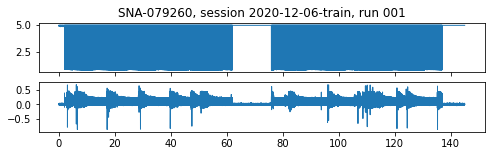

In [6]:
fig, axes = plt.subplots(2,1,sharex=True,figsize=(8,2))
axes[0].plot(time, camera_raw, lw=1)
axes[1].plot(time, trigger_raw, lw=1)
axes[0].set_title(f"{subject}, session {session}, run {run}")

In [7]:
frame_start = np.diff((camera_raw < 2).astype(int)) == 1
triggered   = np.where(trigger_raw > 2)[0]

triggered.size # no value

0

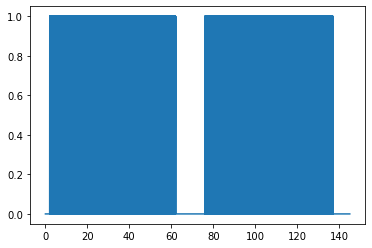

In [8]:
plt.plot(time[:-1], frame_start)

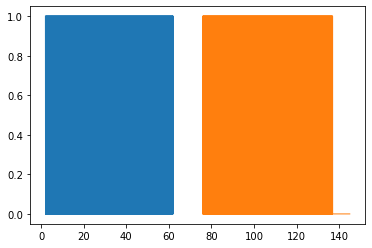

In [9]:
for epoch in split_epochs(frame_start):
    plt.plot(time[epoch], frame_start[epoch], lw=1)

In [10]:
class LatencyDescription(namedtuple("_Latency", ("subject", "session", "run", "epoch",
                                                 "frame_intervals"))):
    @classmethod
    def from_file(cls, path):
        with h5py.File(str(path), "r") as src:
            subject     = src.attrs["subject"]
            session     = src.attrs["session"]
            run         = src.attrs["run"]
            time        = np.array(src["time"])
            camera_raw  = np.array(src["exposure"])
        frame_start = np.diff((camera_raw < 2).astype(int)) == 1
        out = []
        for i, epoch in enumerate(split_epochs(frame_start), start=1):
            out.append(cls(subject, session, run, str(i).zfill(3),
                           np.diff(np.where(frame_start[epoch])[0])))
        return tuple(out)

In [11]:
intervals = LatencyDescription.from_file(srcpath)

In [12]:
intervals[0]

LatencyDescription(subject='SNA-079260', session='2020-12-06-train', run='001', epoch='001', frame_intervals=array([ 28,  98, 100, ..., 100, 100, 100]))

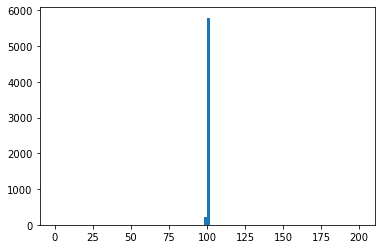

In [13]:
_ = plt.hist(intervals[0].frame_intervals, bins=100, range=(0, 200))

## Overview of a source file (test period)

Need to check whether the trigger is enabled

In [14]:
src_sess = srcroot / "SNA-079258" / "2020-12-06-test"
srcpath  = sorted(src_sess.glob("*.h5"))[0]
srcpath.name

'SNA-079258_2020-12-06-test_spike2_run001.h5'

In [15]:
with h5py.File(str(srcpath), "r") as src:
    subject     = src.attrs["subject"]
    session     = src.attrs["session"]
    run         = src.attrs["run"]
    time        = np.array(src["time"])
    camera_raw  = np.array(src["exposure"])
    trigger_raw = np.array(src["trigger"])
    
frame_start = np.diff((camera_raw < 2).astype(int)) == 1
triggered   = trigger_raw > 2

np.count_nonzero(triggered)

33486

In [19]:
trigger_on = np.where(np.diff(triggered.astype(int)) == 1)[0] + 1

# calculate trigger latency (in samples)
latency = np.empty(trigger_on.size, dtype=np.int64)
MAX_LAT = 500 # 50 ms
for i, _index in enumerate(trigger_on):
    _start = max(0, _index - MAX_LAT)
    _frames = np.where(frame_start[_start:_index])[0]
    if _frames.size > 0:
        _latency = _index - (_start + _frames.max())
    else:
        _latency = np.inf
    latency[i] = _latency

In [21]:
latency

array([ 94, 149, 144, 108, 103,  95, 107,  97,  97, 101,  96, 101,  95,
        95,  96, 103,  94,   4,  95, 101, 100, 114, 104, 105, 103, 107,
        96,  96, 107, 104,  99, 104, 104,  96, 112,  98,  98,  97, 106,
       110, 102,  98,  98, 110,  97,  95,  96, 106, 104, 104, 105,  98,
       101,  95, 119, 100,  97, 114,  98, 107, 103,  97, 101, 129, 164,
       164, 166, 170, 172, 136, 110, 104,  94, 200, 216, 104, 129, 106,
        96,  98,  96,  96,  97, 104, 113,  97,  95,  96,  99, 105,  98,
       104, 109, 106, 108, 107, 138, 162,  95, 111, 135,  97, 111,  97,
        98, 103,  97,  98,  97, 115, 105,  97,  96, 138, 138, 144,  95,
       104, 142, 163, 132,  96,  94,  97,  96, 131,  98,  96,  96, 108,
        97, 112, 148, 171, 100, 105])

In [22]:
def calc_latency(frame_start, triggered, max_latency=500, outlier=-1):
    trigger_on  = np.where(np.diff(triggered.astype(int)) == 1)[0] + 1
    trigger_off = np.where(np.diff(triggered.astype(int)) == -1)[0] + 1
    
    out = []
    for trigger in (trigger_on, trigger_off):
        latency = np.empty(trigger.size, dtype=np.int64)
        for i, _index in enumerate(trigger):
            _start = max(0, _index - max_latency)
            _frames = np.where(frame_start[_start:_index])[0]
            if _frames.size > 0:
                _latency = _index - (_start + _frames.max())
            else:
                _latency = outlier
            latency[i] = _latency
        out.append(latency)
    return tuple(out)

In [23]:
calc_latency(frame_start, triggered)

(array([ 94, 149, 144, 108, 103,  95, 107,  97,  97, 101,  96, 101,  95,
         95,  96, 103,  94,   4,  95, 101, 100, 114, 104, 105, 103, 107,
         96,  96, 107, 104,  99, 104, 104,  96, 112,  98,  98,  97, 106,
        110, 102,  98,  98, 110,  97,  95,  96, 106, 104, 104, 105,  98,
        101,  95, 119, 100,  97, 114,  98, 107, 103,  97, 101, 129, 164,
        164, 166, 170, 172, 136, 110, 104,  94, 200, 216, 104, 129, 106,
         96,  98,  96,  96,  97, 104, 113,  97,  95,  96,  99, 105,  98,
        104, 109, 106, 108, 107, 138, 162,  95, 111, 135,  97, 111,  97,
         98, 103,  97,  98,  97, 115, 105,  97,  96, 138, 138, 144,  95,
        104, 142, 163, 132,  96,  94,  97,  96, 131,  98,  96,  96, 108,
         97, 112, 148, 171, 100, 105]),
 array([ 94, 148, 145,  99,  94,  95, 104, 103, 101, 104,  95,  95, 102,
        104, 102,  95,   3,  95, 105,  95, 105, 101,  95,  97, 103, 102,
         97,  99, 114,  98, 120,  97,  98, 104,  95,  97,  94,  95, 102,
         96

In [24]:
class LatencyDescription(namedtuple("_Latency", ("subject", "session", "run", "epoch", "has_trigger",
                                                 "frame_intervals", "on_latency", "off_latency"))):
    @classmethod
    def from_file(cls, path):
        with h5py.File(str(path), "r") as src:
            subject     = src.attrs["subject"]
            session     = src.attrs["session"]
            run         = src.attrs["run"]
            time        = np.array(src["time"])
            camera_raw  = np.array(src["exposure"])
            trigger_raw = np.array(src["trigger"])
        frame_start = np.diff((camera_raw < 2).astype(int)) == 1
        triggered   = trigger_raw > 2
        
        out = []
        for i, epoch in enumerate(split_epochs(frame_start), start=1):
            _frame = frame_start[epoch]
            _trig  = triggered[epoch]
            _intervals = np.diff(np.where(_frame)[0])
            if np.count_nonzero(_trig) > 0:
                _has_trig = True
                _on_lat, _off_lat = calc_latency(_frame, _trig)
            else:
                _has_trig = False
                _on_lat, _off_lat = None, None
            out.append(cls(subject, session, run, str(i).zfill(3), _has_trig,
                           _intervals, _on_lat, _off_lat))
        return tuple(out)

In [25]:
lat = LatencyDescription.from_file(srcpath)

In [26]:
lat

(LatencyDescription(subject='SNA-079258', session='2020-12-06-train', run='001', epoch='001', has_trigger=True, frame_intervals=array([166, 128, 120, ..., 100, 112, 108]), on_latency=array([ 94, 149, 144, 108, 103,  95, 107,  97,  97, 101,  96, 101,  95,
         95,  96, 103,  94,   4,  95, 101, 100, 114, 104, 105, 103, 107,
         96,  96, 107, 104,  99, 104, 104,  96, 112,  98,  98,  97, 106,
        110, 102,  98,  98, 110,  97,  95,  96, 106, 104, 104, 105,  98,
        101,  95, 119, 100,  97, 114,  98, 107, 103,  97, 101, 129, 164,
        164, 166, 170, 172, 136, 110, 104,  94, 200, 216, 104, 129, 106,
         96,  98,  96,  96,  97, 104, 113,  97,  95,  96,  99, 105,  98,
        104, 109, 106, 108, 107, 138, 162,  95, 111, 135,  97, 111,  97,
         98, 103,  97,  98,  97, 115, 105,  97,  96, 138, 138, 144,  95,
        104, 142, 163, 132,  96,  94,  97,  96, 131,  98,  96,  96, 108,
         97, 112, 148, 171, 100, 105]), off_latency=array([ 94, 148, 145,  99,  94,  95,

In [27]:
latency = tuple()

for subdir in sorted(srcroot.glob("SNA-*")):
    for sessdir in sorted(subdir.glob("2020-*")):
        for srcpath in sorted(sessdir.glob("*.h5")):
            print(f"reading: {srcpath.name}...", end=" ", flush=True)
            latency = latency + LatencyDescription.from_file(srcpath)
            print("done.", flush=True)

reading: SNA-079258_2020-12-04-train_spike2_run001.h5... done.
reading: SNA-079258_2020-12-04-train_spike2_run002.h5... done.
reading: SNA-079258_2020-12-04-train_spike2_run003.h5... done.
reading: SNA-079258_2020-12-06-test_spike2_run001.h5... done.
reading: SNA-079258_2020-12-06-test_spike2_run002.h5... done.
reading: SNA-079258_2020-12-06-test_spike2_run003.h5... done.
reading: SNA-079258_2020-12-06-test_spike2_run004.h5... done.
reading: SNA-079258_2020-12-06-test_spike2_run005.h5... done.
reading: SNA-079258_2020-12-07-test_spike2_run001.h5... done.
reading: SNA-079258_2020-12-07-test_spike2_run002.h5... done.
reading: SNA-079258_2020-12-07-test_spike2_run003.h5... done.
reading: SNA-079258_2020-12-07-test_spike2_run004.h5... done.
reading: SNA-079258_2020-12-11-test_spike2_run001.h5... done.
reading: SNA-079258_2020-12-11-test_spike2_run002.h5... done.
reading: SNA-079258_2020-12-11-test_spike2_run003.h5... done.
reading: SNA-079259_2020-12-06-train_spike2_run001.h5... done.
read

In [28]:
opts = dict(compression=5)
with h5py.File("latency_data.h5", "w") as out:
    frame_intervals = out.create_group("frame_intervals")
    frame_intervals.attrs["description"] = "a set of frame-to-frame intervals during each acquisition period."
    frame_intervals.attrs["unit"] = "samples"
    frame_intervals.attrs["sampling_rate_hz"] = 10000
    
    on_latency = out.create_group("on_latency")
    on_latency.attrs["description"] = "a set of latencies to turn on the trigger after the corresponding exposure-start timings. if it was >50 ms, a `-1` is set."
    on_latency.attrs["unit"] = "samples"
    on_latency.attrs["sampling_rate_hz"] = 10000
    
    off_latency = out.create_group("off_latency")
    off_latency.attrs["description"] = "a set of latencies to turn off the trigger after the corresponding exposure-start timings. if it was >50 ms, a `-1` is set."
    off_latency.attrs["unit"] = "samples"
    off_latency.attrs["sampling_rate_hz"] = 10000
    
    for i, lat in enumerate(latency, start=1):
        print(f"processing: {lat.subject}, session {lat.session}, run {lat.run}, epoch {lat.epoch}...", end=" ", flush=True)
        acq_name = str(i).zfill(3)
        for attr in ("frame_intervals", "on_latency", "off_latency"):
            values = getattr(lat, attr)
            if values is None:
                continue
            acq = out[attr].create_dataset(acq_name, data=values, **opts)
            for metadata in ("subject", "session", "run", "epoch"):
                acq.attrs[metadata] = getattr(lat, metadata)
        frame_intervals[acq_name].attrs["has_trigger"] = lat.has_trigger
        print("done.", flush=True)
print("all acquisitions written to the file.")

processing: SNA-079258, session 2020-12-04-train, run 001, epoch 001... done.
processing: SNA-079258, session 2020-12-04-train, run 002, epoch 001... done.
processing: SNA-079258, session 2020-12-04-train, run 003, epoch 001... done.
processing: SNA-079258, session 2020-12-06-train, run 001, epoch 001... done.
processing: SNA-079258, session 2020-12-06-train, run 002, epoch 001... done.
processing: SNA-079258, session 2020-12-06-train, run 003, epoch 001... done.
processing: SNA-079258, session 2020-12-06-train, run 004, epoch 001... done.
processing: SNA-079258, session 2020-12-06-train, run 005, epoch 001... done.
processing: SNA-079258, session 2020-12-07-train, run 001, epoch 001... done.
processing: SNA-079258, session 2020-12-07-train, run 001, epoch 002... done.
processing: SNA-079258, session 2020-12-07-train, run 002, epoch 001... done.
processing: SNA-079258, session 2020-12-07-train, run 003, epoch 001... done.
processing: SNA-079258, session 2020-12-07-train, run 004, epoch